In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
from sqlalchemy import inspect
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print("----------")
    print(f'Table: {table_name}')
    print("----------")
    for column in inspector.get_columns(table_name):
        print(column['name'], column['type'])

----------
Table: measurement
----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------
Table: station
----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

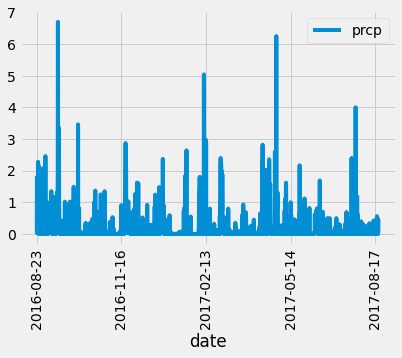

In [194]:
#import requeired
from datetime import datetime
from sqlalchemy import and_



#query1 = "SELECT * FROM measurement WHERE date BETWEEN (SELECT date((SELECT date FROM measurement ORDER BY date DESC LIMIT 1),'-12 month')) AND (SELECT date FROM measurement ORDER BY date DESC LIMIT 1)"
#engine.execute(query1).fetchall()

#Get the last date on the DB and 12 months less (1 year)
last_date = (
    session.query(Measurement.date)
    .order_by(Measurement.date.desc())
    .first()
)
year,month,day = last_date.date.split("-")
finish_date = dt.date(int(year),int(month),int(day))
start_date = dt.date(int(year)-1,int(month),int(day))


# Design a query to retrieve the last 12 months of precipitation data and plot the results
query1 = (
    session
    .query(Measurement.station, Measurement.date, Measurement.prcp)
    .filter(and_(Measurement.date <= finish_date, Measurement.date >= start_date))
)




# Calculate the date 1 year ago from the last data point in the database
#query2 = "SELECT date((SELECT date FROM measurement ORDER BY date DESC LIMIT 1),'-12 month')"
#engine.execute(query2).fetchall()
last_date = (
    session.query(Measurement.date)
    .order_by(Measurement.date.desc())
    .first()
)
year,month,day = last_date.date.split("-")
finish_date = dt.date(int(year),int(month),int(day))
start_date = dt.date(int(year)-1,int(month),int(day))


# Perform a query to retrieve the data and precipitation scores
#query3 = "SELECT station, date, prcp, tobs FROM measurement"
#engine.execute(query3).fetchall()
query3 = session.query(Measurement.station, Measurement.date, Measurement.prcp)#, Measurement.tobs)

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.read_sql(query1.statement, engine)
data = data.set_index(data["date"])

# Sort the dataframe by date
data = data.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
#data["prcp"].unique()
#data["tobs"].unique()
data = data[data['prcp'].notna()]

data.plot.line()
plt.xticks(rotation=90)
plt.show()


In [195]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [146]:
# Design a query to show how many stations are available in this dataset?
#query4 = "SELECT COUNT(DISTINCT station) FROM measurement"
#engine.execute(query4).fetchall()
session.query(Measurement.station).distinct().count()

9

In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
#query5 = "SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC"
#engine.execute(query5).fetchall()
(
    session
    .query(Measurement.station,func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [163]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station(mas)?
#query6 = "SELECT station FROM measurement GROUP BY station ORDER BY COUNT(station) DESC LIMIT 1"
#most_active_station = engine.execute(query6).fetchall()
most_active_station = (
    session
    .query(Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()
)
    
mas_max = session.query(func.max(Measurement.prcp)).filter(Measurement.station == most_active_station.station).all()
mas_avg = session.query(func.avg(Measurement.prcp)).filter(Measurement.station == most_active_station.station).all()
print(f"The most active station is: {most_active_station.station} - the highest temperature recorded was: {mas_max} with average: {mas_avg}")

The most active station is: USC00519281 - the highest temperature recorded was: [(9.64,)] with average: [(0.2123520923520915,)]


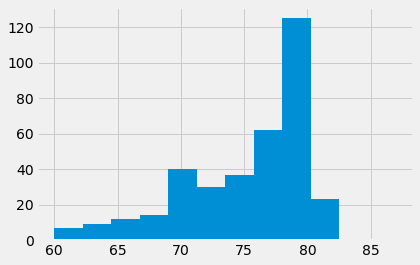

In [182]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_max_temp = (
    session
    .query(Measurement.station)
    .order_by(Measurement.tobs.desc())
    .first()
)
#station_max_temp.station #'USC00519397'


last_date = (
    session.query(Measurement.date)
    .filter(Measurement.station == station_max_temp.station)
    .order_by(Measurement.date.desc())
    .first()
)
year,month,day = last_date.date.split("-")
finish_date = dt.date(int(year),int(month),int(day))
start_date = dt.date(int(year)-1,int(month),int(day))

station_data_query = (
    session
    .query(Measurement)
    .filter(and_(Measurement.station == station_max_temp.station, Measurement.date <= finish_date, Measurement.date >= start_date))
)

station_data = pd.read_sql(station_data_query.statement, engine)
station_data = station_data.set_index(station_data["date"])

plt.hist(x=station_data["tobs"], bins=12)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
